# PTT爬蟲網路範例https://city.shaform.com/blog/2016/02/28/scrapy.html

In [61]:
# -*- coding:utf-8 -*-
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']

%matplotlib notebook

import json
from pprint import pprint #另外加的，這樣輸出比較漂亮

from collections import defaultdict

import jieba #另外安裝
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

#sns.set(style='whitegrid')

In [49]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager
from pylab import mpl
import subprocess

def get_matplot_zh_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
    available = list(mat_fonts & zh_fonts)

    print( '*' * 10, '可用的字体', '*' * 10)
    for f in available:
        print(f)
    return available

def set_matplot_zh_font():
    available = get_matplot_zh_font()
    if len(available) > 0:
        mpl.rcParams['font.sans-serif'] = [available[0]]    # 指定默认字体
        mpl.rcParams['axes.unicode_minus'] = False  

In [50]:
# load ptt posts

path = 'gossip.json'

with open(path) as f:
    posts = json.load(f)
    
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

for post in posts:
    for comment in post['comments']:
        user = comment['user']
        total_comments[user] += 1

        if comment['score'] > 0:
            total_pushes[user] += 1

        elif comment['score'] < 0:
            total_hates[user] += 1
pprint(post)
#print(post)

{'author': 'ukim',
 'comments': [{'content': ': 對啊 如果是不實指控 就告下去啊',
               'score': 1,
               'user': 'huangjyuan'},
              {'content': ': 台女偷吃回娘家都是正常的', 'score': 1, 'user': 'denyy555'},
              {'content': ': 很明顯造謠 誰會那麼蠢在司機面前說要讓表哥做選民服務',
               'score': 0,
               'user': 'saisai34'},
              {'content': ': 台灣價值阿', 'score': 1, 'user': 'k44754'},
              {'content': ': 那好阿 看之後吳會不會告就知道啦', 'score': 1, 'user': 'BEHIND'},
              {'content': ': 告下去，這樣都不告毀謗，吳音寧準備被彈劾',
               'score': -1,
               'user': 'wastetheone'},
              {'content': ': 公道自在人心 吳不必隨之起舞 每個都要告甚麼事都不用做',
               'score': 0,
               'user': 'saisai34'},
              {'content': ': 告下去怕法院認證', 'score': 1, 'user': 'chungu'},
              {'content': ': 哈哈 某人好好笑XDD', 'score': 1, 'user': 'huangjyuan'}],
 'content': '作者ukim (大火球之術)\n'
            '\n'
            '看板Gossiping\n'
            '\n'
            '標題Re: [新聞] 公款買菜送家鄉！吳音寧遭控「指

<IPython.core.display.Javascript object>


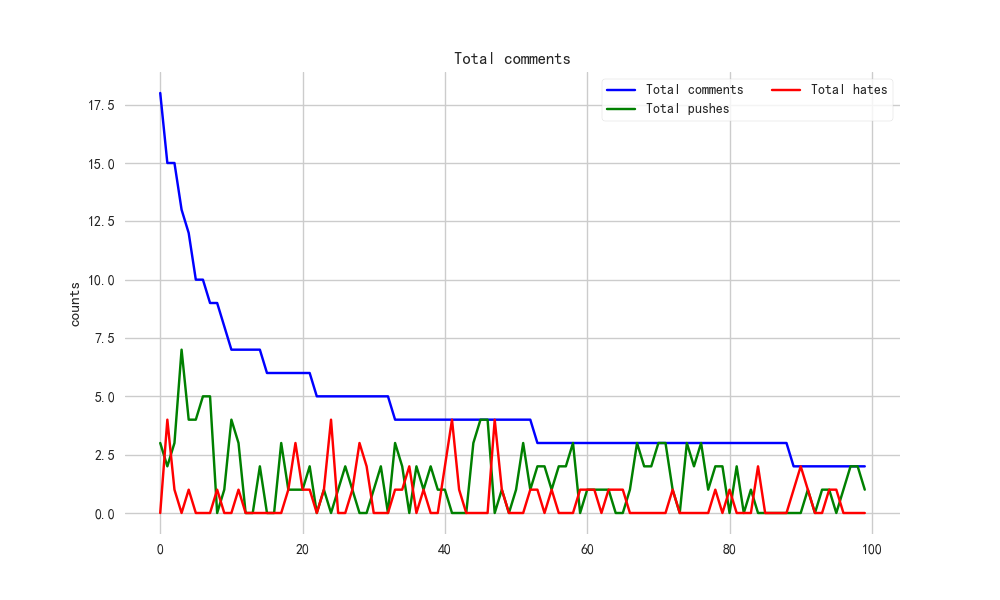

In [51]:
#顯示出這份資料的推、噓多寡分析
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:100]
    y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    x = range(len(y))

    f, ax = plt.subplots(figsize=(10, 6))

    #sns.set_color_codes('pastel')
    plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    plt.plot(x, y_pushes, label='Total {}'.format('pushes'), color='green')
    plt.plot(x, y_hates, label='Total {}'.format('hates'), color='red')

    ax.legend(ncol=2, loc='upper right', frameon=True)
    ax.set(ylabel='counts',
           xlabel='',
           title='Total comments')
    sns.despine(left=True, bottom=True)

    plt.show(f)

# display pushes
show_distributions(total_comments, total_pushes, total_hates)

<IPython.core.display.Javascript object>


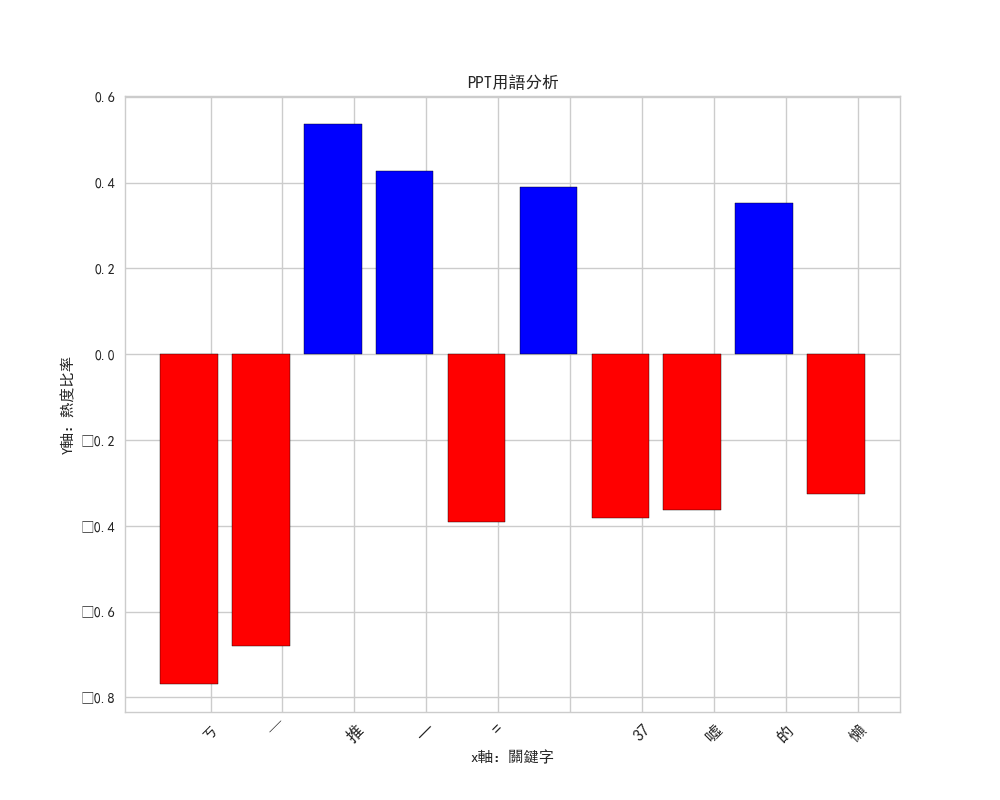

In [68]:
# grap post 用語分析
words = []
scores = []

for post in posts:
    d = defaultdict(int)
    content = post['content']
    if post['score'] != 0:
        for l in content.split('\n'):
            if l:
                for w in jieba.cut(l):
                    d[w] += 1
        if len(d) > 0:
            words.append(d)
            scores.append(1 if post['score'] > 0 else 0)
# grap comments
c_words = []
c_scores = []

for post in posts:
    for comment in post['comments']:
        l = comment['content'].strip()
        if l and comment['score'] != 0:
            d = defaultdict(int)
            for w in jieba.cut(l):
                d[w] += 1
            if len(d) > 0:
                c_scores.append(1 if comment['score'] > 0 else 0)
                c_words.append(d)
                
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

def display_top_features(weights, names, top_n, select=abs):
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')

    width = 0.30
    ax.set_xticks(ind + width)
    #ax.set_xticklabels(top_names, rotation=45, fontsize=12, fontdict={'fontname': 'Droid Sans Fallback', 'fontsize':12})
    ax.set_xticklabels(top_names, rotation=45, fontsize=12)#拿掉不支援的自型後就OK了
    #目前這三格牽一髮而動全身，底下的圖都會跟著變
    #plt.xlabel(u"x軸：關鍵字")
    #plt.ylabel(u"Y軸：熱度比率")
    #plt.title(u"PPT用語分析")
    plt.show(fig)
    
# top features for posts

display_top_features(svc.coef_[0], dvec.get_feature_names(), 10)#原本設定30

<IPython.core.display.Javascript object>


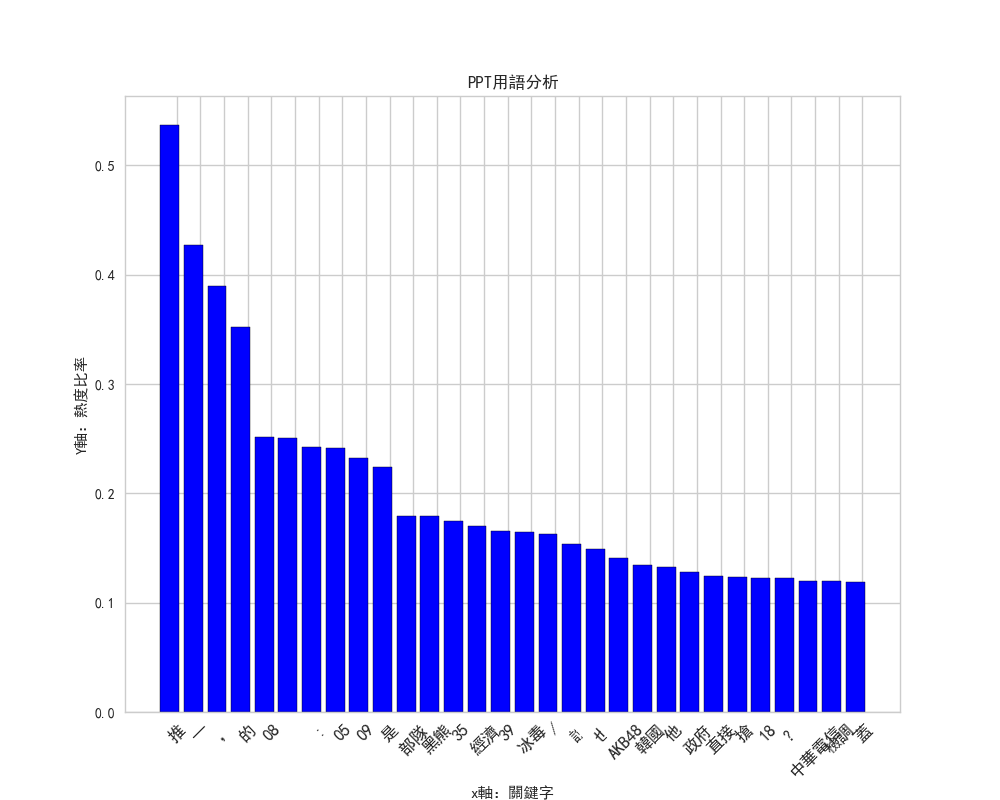

In [69]:
#貼文負向詞彙
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


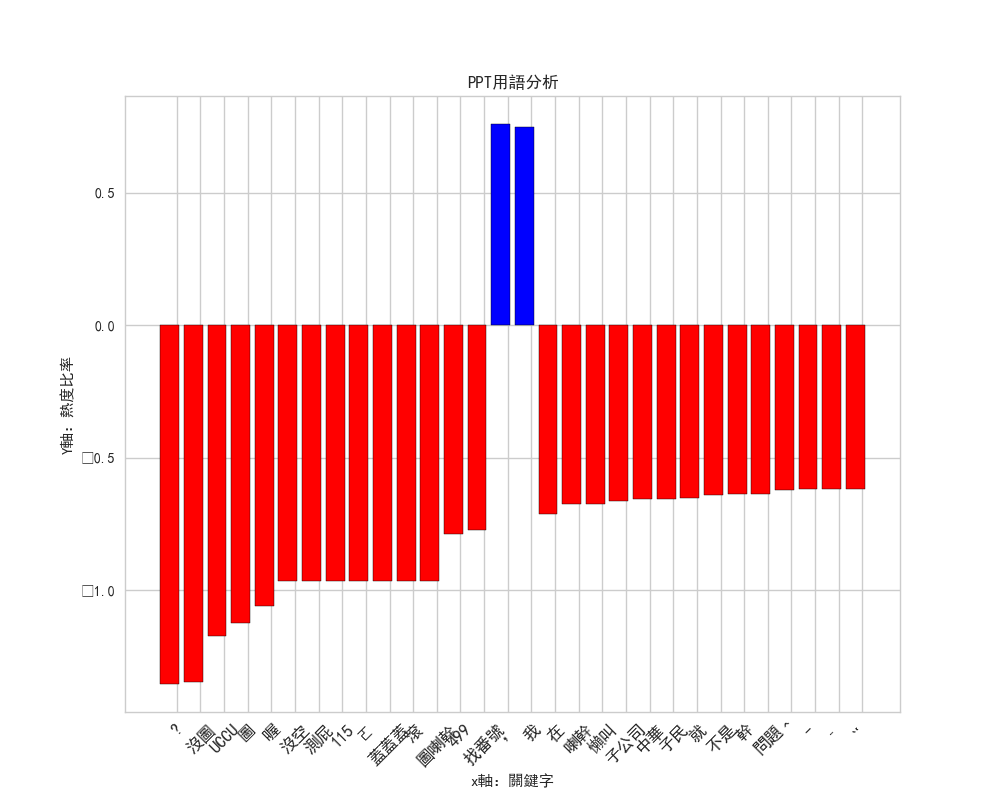

<IPython.core.display.Javascript object>


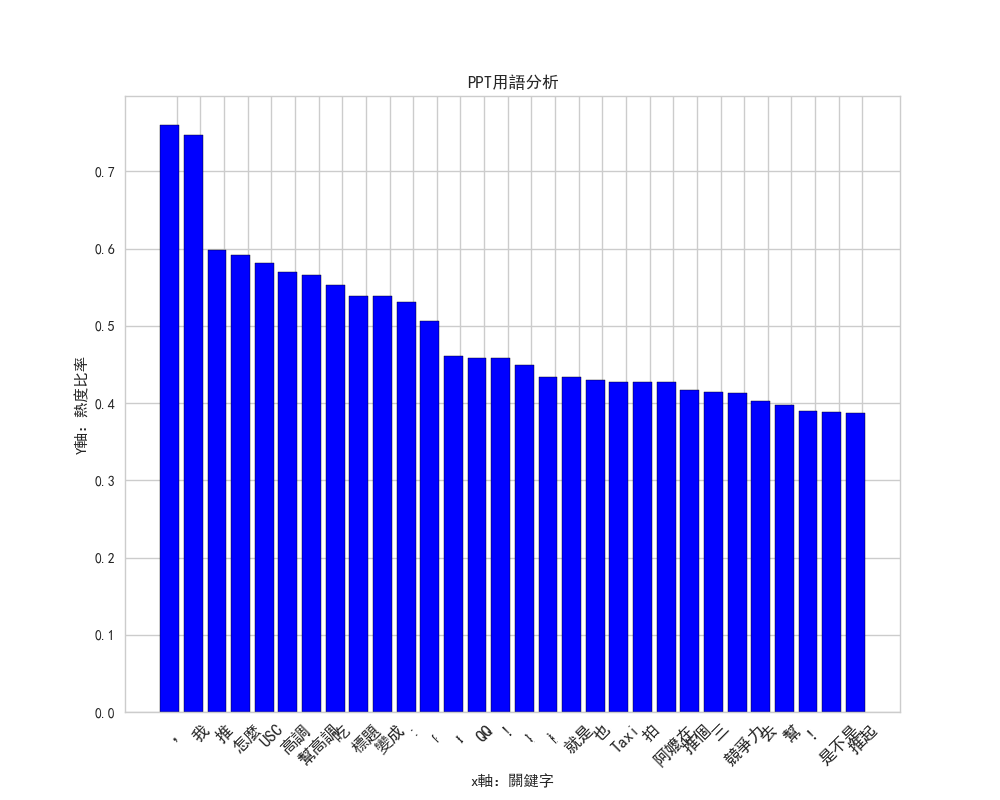

In [70]:
#貼文正向詞彙
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)